# 뉴스기사 요약해보기

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기
- [news_summary_more.csv](https://github.com/sunnysai12345/News_Summary)  
- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습하며, 추출적 요약을 하는 경우에는 text열만을 사용한다.  
- headlines의 내용이 결국 요약문이라고 생각해서 예측 요약과 비교할 실제 요약은 headlines의 내용으로 설정했다.

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
63321,Samsung posts record profit of $10 billion in ...,South Korean tech giant Samsung Electronics on...
31615,Five 'most wanted' ISIS leaders captured in st...,Five senior Islamic State leaders have been ca...
52224,Class 12 student main suspect in Haryana rape ...,A Class 12 student is the prime suspect in the...
51990,"Kim Kardashian, Kanye welcome their 3rd child ...",Reality television star Kim Kardashian and her...
36041,"Army jawan booked for rape, attempt to murder ...",An Army jawan has been booked by the police fo...
42522,NASA model predicts landslides in real-time du...,"Based on satellite data, NASA scientists have ..."
30064,US startup to deliver its electric aircraft in...,US-based startup Zunum Aero has said that it w...
43928,Indo-Pak ceasefire must be on Indian terms: Ar...,Indian Army chief General Bipin Rawat has said...
31140,Gurugram man kills brother over whose turn it ...,A man has been arrested for allegedly killing ...
66396,Nigeria starts 'secret trials' for Boko Haram ...,Nigeria has started 'secret trials' for more t...


## Step 2. 데이터 전처리하기 (추상적 요약)

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [3]:
# 중복 샘플 유무 확인
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# text 중복 샘플 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('test 전체 샘플수 :', (len(data)))

# headlines 중복 샘플 제거
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('headlines 전체 샘플수 :', (len(data)))

test 전체 샘플수 : 98262
headlines 전체 샘플수 : 98262


In [7]:
# Null 값 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거

In [8]:
# 텍스트 정규화를 하기 위한 사전 구성
contractions = {"isn't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  119


In [9]:
# 불용어 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [10]:
# 전처리 함수 만들기
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
# 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않기

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [12]:
# 훈련 데이터 전체에 대해서 전처리하기
# text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것 -> 따로 호출해서 진행

# 전체 text 데이터에 대한 전처리
clean_text = []

for s in data['text']:
    clean_text.append(preprocess_sentence(s))

print("text 전처리 후 결과: ", clean_text[:5])

# 전체 headlines 데이터에 대한 전처리
clean_headlines = []

for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False)) # False : 불용어 제거 수행하지 않는다는 의미

print("headlines 전처리 후 결과: ", clean_headlines[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
# 빈(empty) 값을 Null 값으로 변환
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [14]:
# Null값 재확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299444342675704


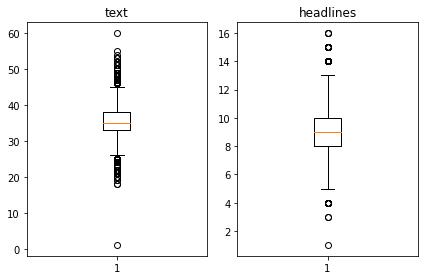

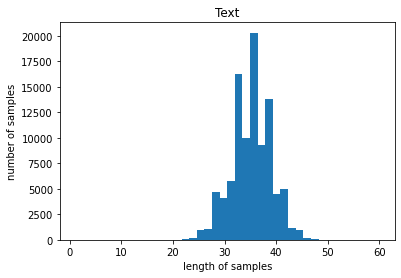

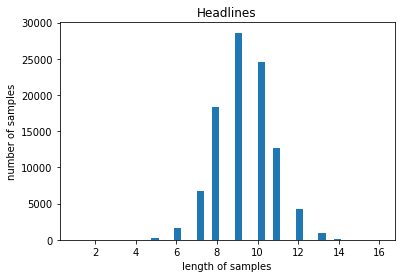

In [17]:
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- text의 경우 최소 길이가 1, 최대 길이가 60. 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 45 내외의 길이를 가진다.  
- headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 매우 짧다. 그래프로 봤을 때에도 대체적으로 14이하의 길이를 가지고 있다.

In [18]:
# text와 headlines 최대 길이 설정
text_max_len = 40
headlines_max_len = 12

In [19]:
# 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수 만들기
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
# 몇 %의 샘플까지 포함하는지 확인
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.92383627444994
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880319960920804


In [21]:
# 설정한 최대 길이를 넘는 문장 제거
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89682


### 시작 토큰과 종료 토큰 추가하기

In [22]:
# headlines 데이터에는 시작 토큰과 종료 토큰을 추가
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x) # 시작 토큰
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken') # 종료 토큰
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


In [23]:
# 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 훈련 데이터와 테스트 데이터 분리하기

In [25]:
# encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 만들기
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 테스트데이터의 크기 정의(8:2)
n_of_val = int(len(encoder_input)*0.2)

# 훈련데이터와 테스트 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71746
훈련 레이블의 개수 : 71746
테스트 데이터의 개수 : 17936
테스트 레이블의 개수 : 17936


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [26]:
# text - 단어 집합 만들기(keras 토크나이저 사용)
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
# 등장 빈도수가 7회 미만인 단어들의 비중
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65572
등장 빈도가 6번 이하인 희귀 단어의 수: 44609
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20963
단어 집합에서 희귀 단어의 비율: 68.03056182516927
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.670106272641426


In [28]:
# 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하기
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[157, 18, 1453, 382, 517, 4840, 245, 5116, 6851, 62, 10793, 941, 4042, 57, 20, 48, 15, 10309, 4716, 1, 1754, 8111, 93, 13358, 1526, 4573, 1129, 2732, 540, 1291, 1, 290, 766, 540, 4793], [43, 432, 12478, 405, 4, 12478, 49, 140, 438, 372, 3076, 4, 43, 7267, 432, 3943, 315, 2208, 25, 619, 1112, 129, 44, 1117, 985, 1761, 140, 477, 387, 5, 338, 300, 12478, 1320], [27, 9615, 1057, 173, 886, 294, 1458, 87, 13359, 31, 2967, 422, 10794, 3797, 1527, 13359, 1399, 19, 660, 387, 54, 9, 1399, 54]]


In [30]:
# headlines - 단어 집합 만들기
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

# 등장 빈도수가 7회 미만인 단어들의 비중
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28810
등장 빈도가 5번 이하인 희귀 단어의 수: 18878
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9932
단어 집합에서 희귀 단어의 비율: 65.52585907670948
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.916052794794512


In [31]:
# 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하기
tar_vocab = 9500
tar_tokenizer = Tokenizer(num_words=tar_vocab) # 단어 집합의 크기를 9,500으로 제한
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2958, 1209, 64, 997, 7294, 389, 37], [1, 100, 74, 135, 452, 129, 9, 603, 937, 2244], [1, 56, 8350, 1396, 208, 1282, 6, 266, 1704, 4, 61], [1, 4697, 3, 21, 276, 5, 1257, 6831, 505, 75], [1, 2485, 20, 1112, 1437, 24, 3332, 1507, 423, 1949]]
target
decoder  [[2958, 1209, 64, 997, 7294, 389, 37, 2], [100, 74, 135, 452, 129, 9, 603, 937, 2244, 2], [56, 8350, 1396, 208, 1282, 6, 266, 1704, 4, 61, 2], [4697, 3, 21, 276, 5, 1257, 6831, 505, 75, 2], [2485, 20, 1112, 1437, 24, 3332, 1507, 423, 1949, 2]]


In [32]:
# headlines에서 길이가 0이 된 샘플들 제거(실제 길이는 1임에 주의)
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]
# headlines에서 길이가 0이 된 샘플들의 인덱스를 받아올 때, 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이기 때문에 실제 길이는 1이라는 것을 주의

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71745
훈련 레이블의 개수 : 71745
테스트 데이터의 개수 : 17936
테스트 레이블의 개수 : 17936


### 패딩하기

In [34]:
# 최대 길이로 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
### 모델 설계

In [35]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128 # 임베딩 벡터 차원
hidden_size = 256 # hidden state 크기(LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터)

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- recurrent dropout : dropout을 레이어가 아닌 time step마다 해주는 방식이다. 즉, time step의 입력을 랜덤으로 생략해준다.

In [36]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [37]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [38]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 학습

In [39]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
# EarlyStopping은 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 훈련을 멈추는 역할을 한다.
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
281/281 [==============================] - 33s 92ms/step - loss: 5.6319 - val_loss: 5.2558
Epoch 2/50
281/281 [==============================] - 25s 89ms/step - loss: 5.0959 - val_loss: 4.8705
Epoch 3/50
281/281 [==============================] - 25s 91ms/step - loss: 4.7347 - val_loss: 4.5955
Epoch 4/50
281/281 [==============================] - 26s 93ms/step - loss: 4.4673 - val_loss: 4.4157
Epoch 5/50
281/281 [==============================] - 26s 91ms/step - loss: 4.2572 - val_loss: 4.2715
Epoch 6/50
281/281 [==============================] - 26s 91ms/step - loss: 4.0770 - val_loss: 4.1642
Epoch 7/50
281/281 [==============================] - 26s 91ms/step - loss: 3.9208 - val_loss: 4.0530
Epoch 8/50
281/281 [==============================] - 26s 92ms/step - loss: 3.7851 - val_loss: 3.9735
Epoch 9/50
281/281 [==============================] - 26s 92ms/step - loss: 3.6682 - val_loss: 3.9314
Epoch 10/50
281/281 [==============================] - 26s 91ms/step - loss: 3.564

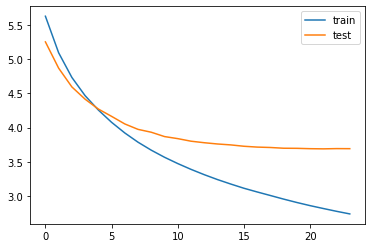

In [40]:
# 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현

In [41]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [42]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [43]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [47]:
# 인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트
        e_h, e_c = h, c

    return decoded_sentence

## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0): 
            # 패딩을 위해 사용되는 숫자 0을 제외
            temp = temp + src_index_to_word[i]+' '
    return temp

# headlines의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            # 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [49]:
# 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : sbi md arijit basu said indian banks consortium recovered crore auction vijay mallya indian properties statement comes london court granted enforcement order favour indian banks seize mallya assets uk hopeful going forward able recover money basu added 
실제 요약 : have recovered cr from mallya assets in india sbi md 
예측 요약 :  sbi to pay cr to cr for cr loan


원문 : andhra pradesh government wednesday signed mou us based hyperloop transportation technologies build india first hyperloop system planned project aimed connecting cities amaravati vijayawada andhra pradesh supposedly covering distance km five minutes mou six month feasibility study would conducted next month 
실제 요약 : andhra pradesh signs mou to build india first hyperloop 
예측 요약 :  andhra cm to get electric car for electric electric


원문 : uber dropped name otto self driving truck unit changed uber advanced technologies group following trademark infringement dispute canadian robotic vehicle technology company named otto moto

예측 요약 :  pakistan thrash pakistan in pakistan after asia cup win


원문 : pv appointed managing director ceo state run corporation bank currently serves executive director canara bank take charge february remain post till march mishra appointed executive director corporation bank 
실제 요약 : pv appointed md and ceo of bank 
예측 요약 :  ceo of ceo sharma ceo quits


원문 : adani group wednesday said would invest crore double capacity company edible oil refinery west bengal created direct indirect jobs bengal adani md pranav adani said added company also exploring logistics 
실제 요약 : adani group to invest crore in west bengal 
예측 요약 :  to buy cr in cr from january


원문 : according reports vidya balan seen portraying gangster upcoming film drama sees leading lady grey character role strong minded woman almost crime report stated film directed jyoti kapur das also penned script 
실제 요약 : vidya balan to play gangster in upcoming film reports 
예측 요약 :  vidya balan to play in film on film


원문 : accordin

예측 요약 :  italian tourist molested by men in us


원문 : germany based researchers claimed brain cells light even one sees familiar face fails identify study recorded activity individual neurons participants shown two familiar images quick succession researchers however observed process weaker delayed unnoticed image compared identified 
실제 요약 : brain recognises faces even when one fails to notice study 
예측 요약 :  scientists find brain to detect brain cells


원문 : according reports actor ajay devgn set play cameo ranveer singh starrer simmba film directed rohit shetty feature ranveer role policeman named sangram ajay worked shetty ten films far reportedly appear character singham cameo 
실제 요약 : devgn to play cameo in ranveer singh starrer simmba reports 
예측 요약 :  ranveer to star in simmba in simmba reports




## Step 5. Summa을 이용해서 추출적 요약해보기

In [68]:
import requests
from summa.summarizer import summarize

data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [78]:
print('원래 문장:', data['text'][10])
print('실제 요약:', data['headlines'][10])
print('예측 요약:', summarize(data['text'][10], ratio=0.5)) # 비율을 조정해서 요약문으로 선택되는 문장의 개수를 조정할 수 있다.

원래 문장: Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school. The cousins revealed their ordeal to the police and Child Welfare Committee after being brought back to Gorakhpur from Nepal, where they had fled to escape the torture.
실제 요약: UP cousins fed human excreta for friendship with boys
예측 요약: Two minor cousins in Uttar Pradesh's Gorakhpur were allegedly repeatedly burnt with tongs and forced to eat human excreta by their family for being friends with two boys from the same school.


- ratio = 0.3으로 설정하니까 예측요약이 아예 나오지 않았다. 짧은 문장이라 비율이 너무 작으면 요약이 되지 않는 거 같다.

In [79]:
print('원래 문장:', data['text'][100])
print('실제 요약:', data['headlines'][100])
print('예측 요약:', summarize(data['text'][100], ratio=0.7, split=True)) # 리스트로 출력 결과를 받고 싶다면 split=True

원래 문장: German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢ÂÂ¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital. Incubated at the Indian Institute of Science (IISc), it provides design and sign-off tools for automotive electronics.
실제 요약: Bosch makes its 1st India investment in IISc spinoff SimYog
예측 요약: ['German multinational engineering and electronics firm Bosch has made its first investment in India in Bengaluru-based deep-tech startup SimYog. SimYog has raised about Ã¢Â\x82Â¹6.3 crore in the funding round, with participation from early-stage venture capital firm Ideaspring Capital.']


In [85]:
print('원래 문장:', data['text'][500])
print('실제 요약:', data['headlines'][500])
print('예측 요약:', summarize(data['text'][500], words=15)) # 단어 수로 요약문 크기 조절

원래 문장: PM Modi on Sunday inaugurated an integrated Bharat Petroleum (BPCL) refinery expansion complex in Kerala's Kochi and dedicated the Ã¢ÂÂ¹16,504-crore investment to the nation. The complex would transform Kochi Refinery as the largest state-run refinery in the country, he said. He also laid the foundation stone for a petrochemical complex at the refinery and a skill development institute at Ettumanoor.
실제 요약: PM Modi inaugurates BPCL's Kochi refinery expansion complex
예측 요약: The complex would transform Kochi Refinery as the largest state-run refinery in the country, he said.


- words=5로 설정하니까 예측 요약이 아예 나오지 않았다. 요약문을 만드는 데에도 문법적으로 말이 되도록 하려면 최소 단어 수가 있는 거 같다.

------

## 회고
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었는가?  
분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩까지 실행하였다. lms를 바탕으로 그대로 따라했기 때문에 따라하는 과정은 어렵지 않았지만 나혼자 처음부터 해야한다면 굉장히 막막했을 거 같다. 프로젝트를 제출하기는 했지만 계속 반복해서 전처리 과정을 보면서 익숙해지도록 더욱 노력해야겠다.  
2. 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었는가?  
train los와 validation loss가 감소하는 경향을 그래프를 통해 확인하였는데, early stopping이 없었다면 validation loss가 다시 증가하는 상황이 벌어질 수도 있겠다고 느꼈다. 학습에 있어 epoch을 적절하게 설정하는 것도 중요하고 early stopping이 과도하게 학습되는 것을 방지해주는 것을 봤을 때 정말 좋은 기능이라고 느꼈다. 그렇게 학습된 것을 가지고 예측 요약을 봤을 때, 잘못 요약된 것도 어느 부분 있기는 하지만 실제 요약과 비슷하게 나오는 경우도 있었다.  
3. Extractive 요약과 Abstractive 요약 결과를 비교해보았는가?  
문법완성도 측면에서는 Extractive 요약이 더 좋아보인다. 문장에 따라 ratio나 words의 설정을 너무 작게 하면 예측 요약이 아예 나오지 않았는데, 핵심단어를 뽑아내면서 문법적으로 맞추기 위해서는 어느 정도 길이가 필요하기 때문이라고 생각했다. 반면, 핵심단어 포함 측면에서는 Abstractive 요약이 더 좋아보인다. Abstractive 요약은 상대적으로 문법보다 핵심단어를 뽑아내는데 중점을 둔 요약이라는 생각이 들었다.